In [1]:
import matplotlib.font_manager
from IPython.core.display import HTML
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random 
import csv

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

plt.rcParams["font.family"] = "TeX Gyre Schola Math"

print("Likelihood")

Likelihood


## Import the data

### Importing the data from Gaia

In [2]:
def OutCVSGaia(name):
    #___ Description_____________________________________________________________________________________
    #Arguments:: name of the file to be read
    #Returns:: list of lists with either all the velocity components as seen from Earth, or  with all the 
    #         positions of the ellipse for the model
    #____________________________________________________________________________________________________
  
    LIST1, LIST2, LIST3, LIST4, LIST5, LIST6 = [], [], [], [], [], []
    with open('ThisIsTheData/' + name + '.csv', 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            LIST1.append(float(row[0])) #x position
            LIST2.append(float(row[1])) #y position
            LIST3.append(float(row[2])) #pmra
            LIST4.append(float(row[3])) #sigma on the pmra
            LIST5.append(float(row[4])) #pmdec
            LIST6.append(float(row[5])) #sigma on the pmdec
            
    return LIST1, LIST2, LIST3, LIST4, LIST5, LIST6

In [11]:
#We first import all the position of the different stars
x_All, y_All, pmra_All, pmra_sig_All, pmdec_All, pmdec_sig_All       = OutCVSGaia('AllStars')
x_Blue, y_Blue, pmra_Blue, pmra_sig_Blue, pmdec_Blue, pmdec_sig_Blue = OutCVSGaia('BlueStars')
x_Red, y_Red, pmra_Red, pmra_sig_Red, pmdec_Red, pmdec_sig_Red       = OutCVSGaia('RedStars')

### Organising the data from the Gaia data

In [46]:
def OrganiseGaiaData(x, y, pmra, pmra_e, pmdec, pmdec_e):
    #___ Description_____________________________________________________________________________________
    #Arguments:: gives all the relevant quantities
    #Returns:: list with all the different significant quantities localised in it
    #____________________________________________________________________________________________________
     
    GaiaData = []
    
    GaiaData.append(x)
    GaiaData.append(y)
    GaiaData.append(pmra)
    GaiaData.append(pmra_e)
    GaiaData.append(pmdec)
    GaiaData.append(pmdec_e)
    
    return GaiaData

In [47]:
GaiaDataAll  = OrganiseGaiaData(x_All, y_All, pmra_All, pmra_sig_All, pmdec_All, pmdec_sig_All)
GaiaDataBlue = OrganiseGaiaData(x_Blue, y_Blue, pmra_Blue, pmra_sig_Blue, pmdec_Blue, pmdec_sig_Blue)
GaiaDataRed  = OrganiseGaiaData(x_Red, y_Red, pmra_Red, pmra_sig_Red, pmdec_Red, pmdec_sig_Red)

### Importing the data from the model

In [4]:
def OutCVSModel(name):
    #___ Description_____________________________________________________________________________________
    #Arguments:: name of the file to be read
    #Returns:: list of lists with either all the velocity components as seen from Earth, or  with all the 
    #         positions of the ellipse for the model
    #____________________________________________________________________________________________________
  
    LIST1, LIST2, LIST3 = [], [], []
    if name != "model":
        with open('ThisIsTheData/' + name + '.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                LIST1.append([float(row[0]), float(row[1])])
        return LIST1
    
    else:
        with open('ThisIsTheData/' + name + '.csv', 'r') as file:
            reader = csv.reader(file)
            for row in reader:
                LIST1.append(float(row[0]))
                LIST2.append(float(row[1]))
                LIST3.append(-float(row[2]))
        return LIST1, LIST2, LIST3        

In [5]:
#Reading the cvs files
xb = OutCVSModel('x_edges') #all x the edges of the bins
yb = OutCVSModel('y_edges') #all the y edges of the bins
vb = OutCVSModel('vel')     #all the heliocentric velocities of the bins

x_model, y_model, z_model = OutCVSModel("model")

## Superimposing the model with the data 

We will first do a sort of visual check to see if the model we have and the data coming from gaia actually do match, and as we can see below, they seem to match pretty well. Noice.

findfont: Font family ['TeX Gyre Schola Math'] not found. Falling back to DejaVu Sans.


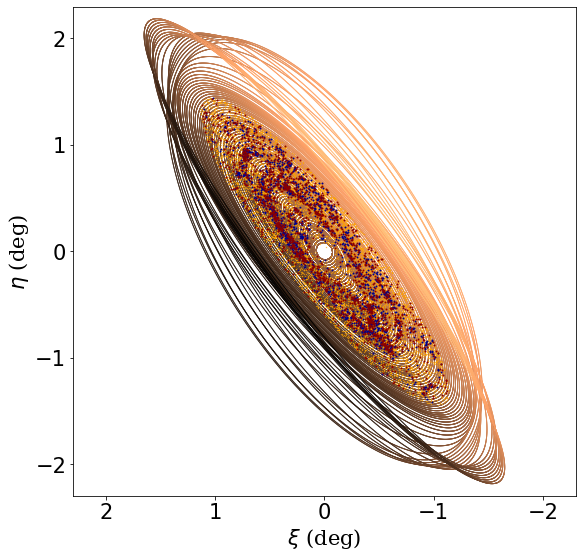

In [6]:
plt.figure(figsize=(9, 9))
#Plot the background:
plt.scatter(x_model, y_model, c=z_model, cmap='copper', s=1, linewidth=0)

#Plot of the stars coming from gaia
plt.scatter(x_All, y_All, s=0.1, color='orange')
plt.scatter(x_Blue, y_Blue, s=0.9, color='darkblue')
plt.scatter(x_Red, y_Red, s=0.9, color='darkred')

plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xlim(-2.3, 2.3)
plt.ylim(-2.3, 2.3)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('Superimposed.png', dpi=500)
plt.show()

## Velocity of the stars from Gaia

In this section we will create a function that will allow us to know in which bin a star is located and hence go back to the velocity with which it should be observed based on the rotation model (in the heliocentric frame).

In [263]:
def FindBin(x, y, x_intervals, y_intervals, vel):
    #___ Description_____________________________________________________________________________________
    #Arguments:: coordinates of the point, lists of the intervals (along x and y) and the list of the 
    #           components of the velocity along each axis
    #Returns:: returns the components of the velocity in the bin in mas/yr
    #____________________________________________________________________________________________________
     
    #We first determine in which bin the point/star is located
    count = 0
    for i in range(len(x_intervals)):
        if x > x_intervals[i][0] and x < x_intervals[i][1]:
            if y > y_intervals[i][0] and y < y_intervals[i][1]:
                count = i    
                
    #Let's convert the velocity from km/s to mas/yr
    RadDist = 780*3.08E16 #Radial distance from M31 in km
    YrToSec = 365.25*86400 #Years to seconds
    
    pm_ra  = ((vel[count][0]*YrToSec)/(RadDist*4.84814E-12))
    pm_dec = (vel[count][1]*YrToSec)/(RadDist*4.84814E-12)

    return pm_ra, pm_dec

### Organising the data from the model

In [262]:
def OrganiseModelData(x_stars, y_stars, x_bounds, y_bounds, vel):
    #___ Description_____________________________________________________________________________________
    #Arguments:: 'x' and 'y_stars' are lists of the coordinates of the star for which we want the proper
    #           motion. 'x' and 'y_bounds' are the limits of the bins of the model and 'vel' the 
    #           velocities associated in each of those
    #Returns:: returns a list with all the proper motions of the stars in mas/yr
    #____________________________________________________________________________________________________

    ModelData = [[], []]
        
    for i in range(len(x_stars)):
        Temporary = FindBin(x_stars[i], y_stars[i], xb, yb, vb)
        ModelData[0].append(Temporary[0])
        ModelData[1].append(Temporary[1])
    
    return ModelData

In [203]:
ModelDataAll  = OrganiseModelData(GaiaDataAll[0], GaiaDataAll[1], xb, yb, vb)
ModelDataBlue = OrganiseModelData(GaiaDataBlue[0], GaiaDataBlue[1], xb, yb, vb)
ModelDataRed  = OrganiseModelData(GaiaDataRed[0], GaiaDataRed[1], xb, yb, vb)

#### Let's quickly visualise if this worked superimposing the velocities from the model that we gave to the stars of the Gaia data

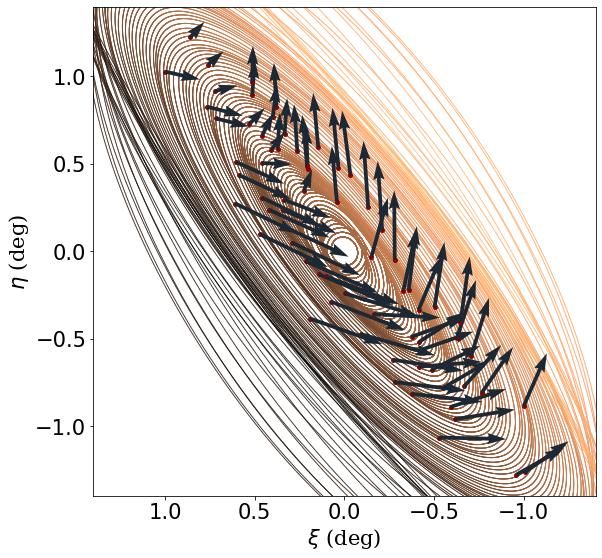

In [37]:
plt.figure(figsize=(9, 9))
plt.scatter(x_model, y_model, c=z_model, cmap='copper', s=1, linewidth=0)

for i in range(len(x_Red)):
    if i % 2 == 0:
        if i % 3 == 0:
            if i %5 == 0:
                plt.scatter(x_Red[i], y_Red[i], s=15, color='darkred')
                plt.quiver(x_Red[i], y_Red[i], ModelDataRed[0][i]*0.005, ModelDataRed[1][i]*0.005, angles='xy', scale_units='xy', scale=1, color='#1c2833') 
                
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xlim(-1.4, 1.4)
plt.ylim(-1.4, 1.4)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('42.png', dpi=150)
plt.show()

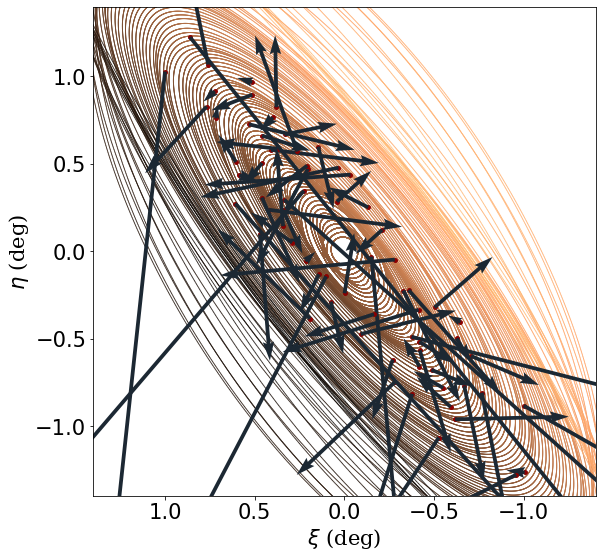

In [261]:
plt.figure(figsize=(9, 9))
plt.scatter(x_model, y_model, c=z_model, cmap='copper', s=1, linewidth=0)

for i in range(len(x_Red)):
    if i % 2 == 0:
        if i % 3 == 0:
            if i %5 == 0:
                plt.scatter(x_Red[i], y_Red[i], s=15, color='darkred')
                plt.quiver(x_Red[i], y_Red[i], GaiaDataRed[2][i], GaiaDataRed[4][i], angles='xy', scale_units='xy', scale=1, color='#1c2833') 
                
plt.xlabel(r'$\xi$ (deg)', fontname = 'Serif', size = 21)
plt.ylabel(r'$\eta$ (deg)', fontname = 'Serif', size = 21)
plt.xlim(-1.4, 1.4)
plt.ylim(-1.4, 1.4)
plt.xticks(fontsize = 21)
plt.yticks(fontsize = 21)
plt.gca().invert_xaxis()
#plt.savefig('42.png', dpi=150)
plt.show()

In [290]:
class LikelihooD():
    #____Constructor::___________________________________________________________________________________
    def __init__(self, NbModels, GaiaData, ModelData):
        self.NbModels = NbModels
        
        self.mu_ra_gaia       = GaiaData[2]
        self.mu_ra_sig_gaia   = GaiaData[3]
        self.mu_dec_gaia      = GaiaData[4]
        self.mu_dec_sig_gaia  = GaiaData[5]
        
        self.mu_ra_model  = ModelData[0]
        self.mu_dec_model = ModelData[1]  
        
    #____Methods::_______________________________________________________________________________________
    def Execute(self):
        #Let's first execute the command that will create the lists of free parameters (f.p.)
        self.FreeParameters()
        
        #Create the function that will contain the values of the likelihood for a given f.p. couple
        self.LikelihoodList = []
        
        for i in range(len(self.pm_ra_M31)): #Loop over the 'ra' parameters
            self.LikelihoodList.append([])
            for j in range(len(self.pm_dec_M31)): #Loop over the 'dec' parameters
                self.LikelihoodList[i].append([1.])
                for k in range(len(self.mu_ra_gaia)): #Loop over all the stars 
                    l = self.LikelihoodSingleStar(k, i, j)
                    if l == 0:
                        self.LikelihoodList[i][j][0] *= 0.01
                    else:
                        self.LikelihoodList[i][j][0] *= l
                    #print("Theory:", self.pm_ra_M31[i] + self.mu_ra_model[k])
                    #print("Data:", self.mu_ra_gaia[k])

                #print(self.LikelihoodList[i][j][0])

    
    def FreeParameters(self):
        self.pm_ra_M31  = np.linspace(13, 80, self.NbModels) #from 50km/s to 300km/s
        self.pm_dec_M31 = np.linspace(1, -92, self.NbModels) #from 0km/s to -350km/s
                
    def LikelihoodSingleStar(self, index_star, index_model_ra, index_model_dec):
        GaussianCenter_ra  = self.pm_ra_M31[index_model_ra] + self.mu_ra_model[index_star]
        GaussianCenter_dec = self.pm_dec_M31[index_model_dec] + self.mu_dec_model[index_star]

        PreFactor = 1/(2*np.pi*self.mu_ra_sig_gaia[index_star]*self.mu_dec_sig_gaia[index_star])    
        ExpRa  = np.exp(-0.5*((self.mu_ra_gaia[index_star] - GaussianCenter_ra)/self.mu_ra_sig_gaia[index_star])**2)
        ExpDec = np.exp(-0.5*((self.mu_dec_gaia[index_star] - GaussianCenter_dec)/self.mu_dec_sig_gaia[index_star])**2)
        
        return (PreFactor*ExpRa*ExpDec)

In [291]:
ObjLike = LikelihooD(3, GaiaDataBlue, ModelDataBlue)
ObjLike.Execute()